## Autoencoders

In [353]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from pathlib import Path
import os

import matplotlib.pyplot as plt

### MINIST dataset

In [49]:
PATH = Path("/data2/yinterian/data")

In [81]:
trans = transforms.Compose([transforms.ToTensor()])
train_ds = MNIST(PATH, train=True, transform=trans, download=True)
val_ds = MNIST(PATH, train=False, transform=trans, download=True)

In [82]:
x, y = train_ds[0]

In [83]:
x.shape

torch.Size([1, 28, 28])

In [84]:
y

tensor(5)

In [96]:
batch_size = 256
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

### Autoencoder model 

In [98]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [99]:
learning_rate = 1e-3
model = autoencoder().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [100]:
criterion = nn.MSELoss()
def val_loss(model, val_dl):
    model.eval()
    total_loss = 0.0
    total = 0
    for x, _ in train_dl:
        x = x.cuda()
        output = model(x)
        loss = criterion(output, x)
        total += x.size(0)
        total_loss += x.size(0)*loss.item()
    return total_loss/total     

In [101]:
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    for x, _ in train_dl:
        x = x.cuda()
        output = model(x)
        loss = criterion(output, x)
                       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                       
    if epoch % 10 == 0:
        valid_loss = val_loss(model, val_dl)
        print('epoch [{}/{}], loss:{:.4f} val_loss:{:.4f}'.format(epoch+1, num_epochs, loss.item(), valid_loss))

torch.save(model.state_dict(), PATH/"conv_autoencoder.pth")

epoch [1/40], loss:0.0637 val_loss:0.0632
epoch [11/40], loss:0.0336 val_loss:0.0328
epoch [21/40], loss:0.0297 val_loss:0.0291
epoch [31/40], loss:0.0271 val_loss:0.0272


## Results on new data

In [120]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [121]:
model = autoencoder().cuda()
load_model(model, PATH/"conv_autoencoder.pth")

In [122]:
val_dl = DataLoader(val_ds, batch_size=4, shuffle=False)

In [123]:
x, y = next(iter(val_dl))

In [124]:
x.shape

torch.Size([4, 1, 28, 28])

In [125]:
def to_image(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

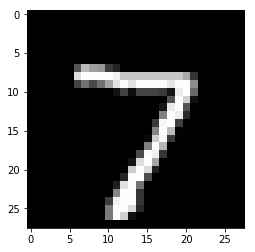

In [126]:
plt.imshow(x[0][0], cmap='gray')

In [127]:
x_hat = model(x.cuda())

In [128]:
img_hat = to_image(x_hat.cpu().detach())

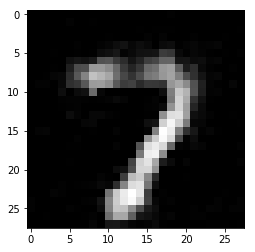

In [130]:
plt.imshow(img_hat[0][0], cmap='gray')

## Variational Autoencoder

### Model

In [330]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [331]:
class UnFlatten(nn.Module):
    def forward(self, input, size=128):
        return input.view(input.size(0), size, 1, 1)

In [339]:
class VAE(nn.Module):
    def __init__(self, h_dim=128, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z

    def encode(self, x):
        h = self.encoder(x)
        # bottleneck
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [340]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [341]:
model = VAE().cuda()

In [342]:
x, y = next(iter(train_dl))

In [343]:
x.shape

torch.Size([64, 1, 28, 28])

In [345]:
x_hat, _, _ = model(x.cuda())
x_hat.shape

torch.Size([64, 1, 28, 28])

### Loss
Reconstruction + KL divergence losses summed over all elements and batch <br>
see Appendix B from VAE paper: <br>
Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014 <br>
https://arxiv.org/abs/1312.6114 <br>
-0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2) <br>

https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians

In [361]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def loss_fn(recon_x, x, mu, logvar):
    # BCE = F.mse_loss(recon_x, x, size_average=False)
    bce = F.binary_cross_entropy(recon_x.view(-1), x.view(-1), size_average=False)
    kld = -0.5 * torch.sum(1 + 2*logvar - mu.pow(2) - logvar.exp())
    return bce + 3 * kld, bce, kld

In [372]:
def train_vae(model, optimizer, epochs=10):
    for epoch in range(epochs):
        total_loss = 0.0
        total_bce = 0.0
        total_kld = 0.0
        total = 0
        for x, _ in train_dl:
            x = x.cuda()
            x_hat, mu, logvar = model(x)
            loss, bce, kld = loss_fn(x_hat, x , mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_bce += bce.item()
            total_kld += kld.item()
            total += x.size(0)

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(
            epoch+1, epochs, total_loss/total, total_bce/total, total_kld/total)
        print(to_print)

In [373]:
model = VAE().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

RuntimeError: CUDA error: device-side assert triggered

In [370]:
train_vae(model, optimizer)

RuntimeError: reduce failed to synchronize: device-side assert triggered

In [355]:
train_vae(model)

/home/yinterian/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/10] Loss: 182.487 185.001 -0.838
Epoch[2/10] Loss: 153.675 144.370 3.101
Epoch[3/10] Loss: 149.426 136.683 4.248
Epoch[4/10] Loss: 147.614 133.234 4.793
Epoch[5/10] Loss: 146.511 131.212 5.099
Epoch[6/10] Loss: 145.679 129.859 5.273
Epoch[7/10] Loss: 145.266 128.887 5.460
Epoch[8/10] Loss: 144.782 127.966 5.605
Epoch[9/10] Loss: 144.451 127.294 5.719
Epoch[10/10] Loss: 144.116 126.602 5.838


In [356]:
train_vae(model, epochs=20)

Epoch[1/20] Loss: 143.672 125.455 6.072
Epoch[2/20] Loss: 143.263 124.601 6.221
Epoch[3/20] Loss: 143.082 124.098 6.328
Epoch[4/20] Loss: 142.827 123.647 6.393
Epoch[5/20] Loss: 142.579 123.339 6.413
Epoch[6/20] Loss: 142.425 123.057 6.456
Epoch[7/20] Loss: 142.245 122.691 6.518
Epoch[8/20] Loss: 142.125 122.353 6.591
Epoch[9/20] Loss: 142.045 122.191 6.618
Epoch[10/20] Loss: 141.855 121.897 6.653
Epoch[11/20] Loss: 141.865 121.688 6.725
Epoch[12/20] Loss: 141.701 121.530 6.724
Epoch[13/20] Loss: 141.630 121.344 6.762


KeyboardInterrupt: 

## References
* https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder
* https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb